# Explore the correct procedure of single lens imaging

In [1]:
import numpy
import sys
import os
import matplotlib.pyplot as plt
import skimage.io as sio
from skimage.transform import resize
%matplotlib inline
import imp
sys.path.append("D:\\Workspace\\git_proj\\CCCode\\")
import imaging_process

In [2]:
imp.reload(imaging_process)
from imaging_process import Check, Wavefront, img_val_norm

PIXEL_SIZE = 5e-6
PIXEL_NUM = 512
WAVELENGTH = 500e-9

# import images
imgs_path = "D:\\Workspace\\datasets\\open_image_val_standard"
imgs_name_list = os.listdir(imgs_path)[0:2]
imgs_fpath_list = [os.path.join(imgs_path, img_name) for img_name in imgs_name_list]
amp_img = img_val_norm(resize(sio.imread(imgs_fpath_list[0]), (PIXEL_NUM, PIXEL_NUM)), 0.1, 1)
pha_img = img_val_norm(resize(sio.imread(imgs_fpath_list[1]), (PIXEL_NUM, PIXEL_NUM)), 0.2, 1.5)

wf_obj = Wavefront.from_bioimage(amp_img, pha_img, WAVELENGTH, PIXEL_SIZE)
wf_init_ft = wf_obj.spatial_transfer(1e-3).wavefront_ft

拦截: spatial_transfer
拦截: _coordinate_fre
拦截: wavefront
拦截: p_s
拦截: p_s
拦截: p_s
拦截: p_s
拦截: k
拦截: k
拦截: k
拦截: wavefront
拦截: wavefront_ft


# Varify the equivalence between spectral shift and tilt phase

In [50]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Propagate import validate_spectrum_pan, ft2, ift2
import numpy as np

w0, CTF, w1_0, w1_1, CTF_tile, w1_11 = validate_spectrum_pan()

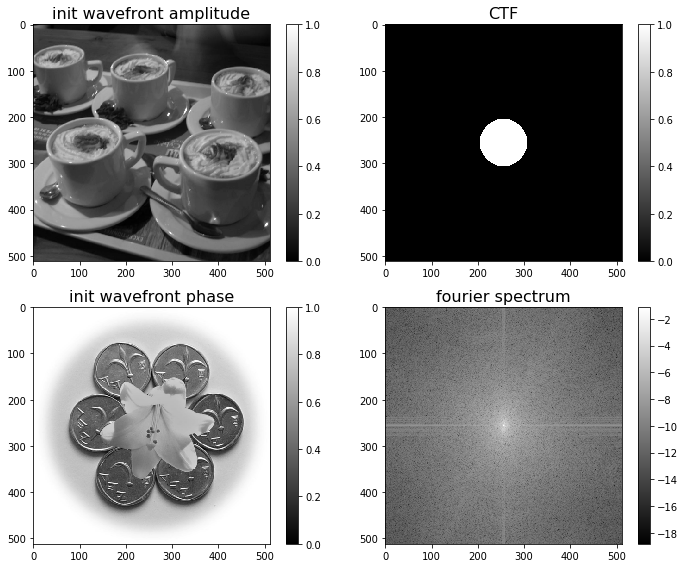

In [25]:
plt.figure(figsize=[10, 8])
plt.subplot(221)
plt.imshow(abs(w0), cmap="gray")
plt.title("init wavefront amplitude", fontsize=16)
plt.colorbar()
plt.subplot(222)
plt.imshow(CTF, cmap="gray")
plt.title("CTF", fontsize=16)
plt.colorbar()
plt.subplot(223)
plt.imshow(np.angle(w0), cmap="gray")
plt.title("init wavefront phase", fontsize=16)
plt.colorbar()
plt.subplot(224)
plt.imshow(np.log(abs(ift2(w0))), cmap="gray")
plt.title("fourier spectrum", fontsize=16)
plt.colorbar()
plt.tight_layout()
plt.show()

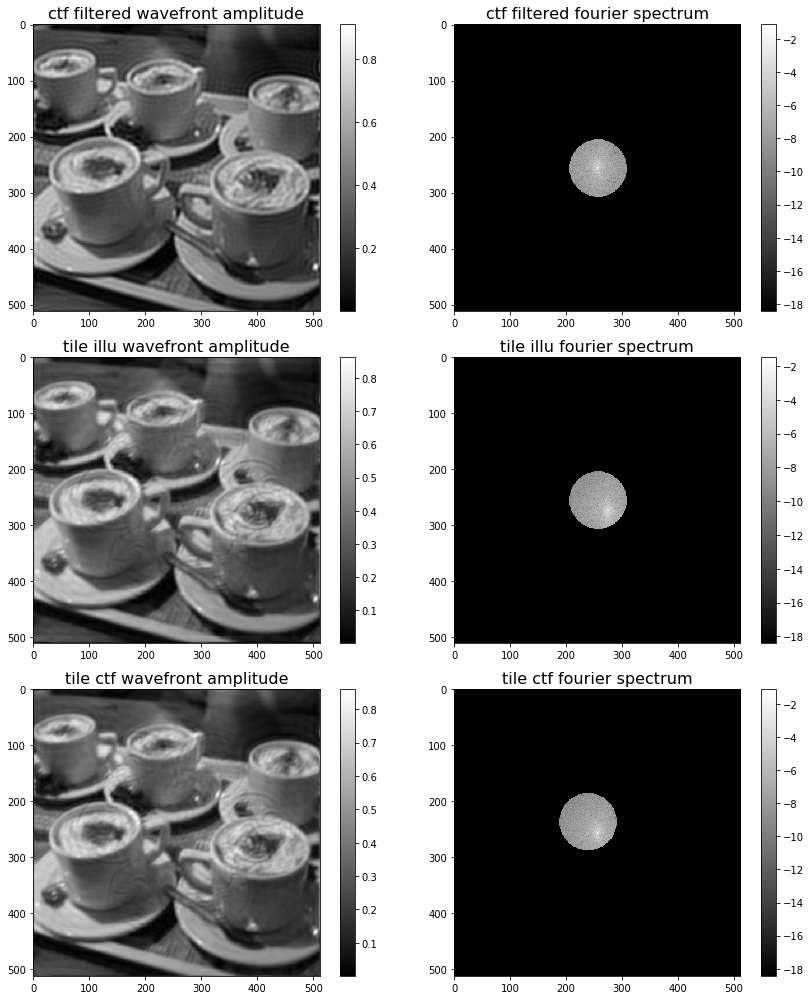

In [51]:
plt.figure(figsize=[12, 14])
plt.subplot(321)
plt.imshow(abs(w1_0), cmap="gray")
plt.title("ctf filtered wavefront amplitude", fontsize=16)
plt.colorbar()
plt.subplot(322)
plt.imshow(np.log(abs(ift2(w1_0))+1e-8), cmap="gray")
plt.title("ctf filtered fourier spectrum", fontsize=16)
plt.colorbar()
plt.subplot(323)
plt.imshow(abs(w1_1), cmap="gray")
plt.title("tile illu wavefront amplitude", fontsize=16)
plt.colorbar()
plt.subplot(324)
plt.imshow(np.log(abs(ift2(w1_1))+1e-8), cmap="gray")
plt.title("tile illu fourier spectrum", fontsize=16)
plt.colorbar()
plt.subplot(325)
plt.imshow(abs(w1_11), cmap="gray")
plt.title("tile ctf wavefront amplitude", fontsize=16)
plt.colorbar()
plt.subplot(326)
plt.imshow(np.log(abs(ift2(w1_11))+1e-8), cmap="gray")
plt.title("tile ctf fourier spectrum", fontsize=16)
plt.colorbar()
plt.tight_layout()
plt.show()

# Generate Multi-focus Intensity Images 

In [2]:
import numpy as np
from skimage import io
from skimage.transform import resize
from ForwardImaging.util import forward_propagate
import matplotlib.pyplot as plt
import scipy.io as sio
import os

In [8]:
# params setting
d = 0.0005
pixel_num = 512
pixel_size = 5e-6
wavelength = 5e-7

def img_val_scale(img, min_val=0., max_val=1.):
    img = img - img.min()
    img = img / img.max()
    
    img_val_range = max_val - min_val
    img = img * img_val_range + min_val
    return img

# load images
amp_img = resize(io.imread("./data/a.jpg"), (pixel_num, pixel_num))
pha_img = resize(io.imread("./data/b.jpg"), (pixel_num, pixel_num))

# normalization
amp_img = (amp_img - amp_img.min()) / (amp_img - amp_img.min()).max()
pha_img = np.pi * (pha_img - pha_img.min()) / (pha_img - pha_img.min()).max()
amp_img = img_val_scale(amp_img, 0.9, 1.)
pha_img = img_val_scale(pha_img, 0.5, 1.5)

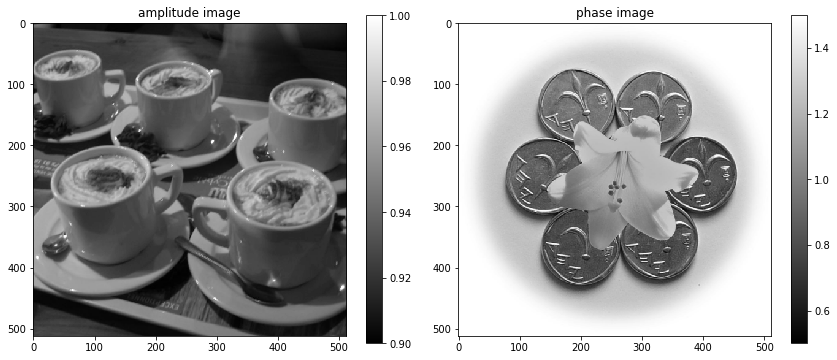

In [11]:
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.imshow(amp_img, cmap="gray")
plt.title("amplitude image")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(pha_img, cmap="gray")
plt.title("phase image")
plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
# wavefront
wf_init = amp_img * np.exp(1j * pha_img)

# propagating
wf_unfocus = forward_propagate(wf_init, d, wavelength, pixel_num, pixel_size)
wf_defocus = forward_propagate(wf_init, -d, wavelength, pixel_num, pixel_size)
I_unfocus = abs(wf_unfocus * wf_unfocus.conj())
I_defocus = abs(wf_defocus * wf_defocus.conj())
I_infocus = abs(wf_init * wf_init.conj())

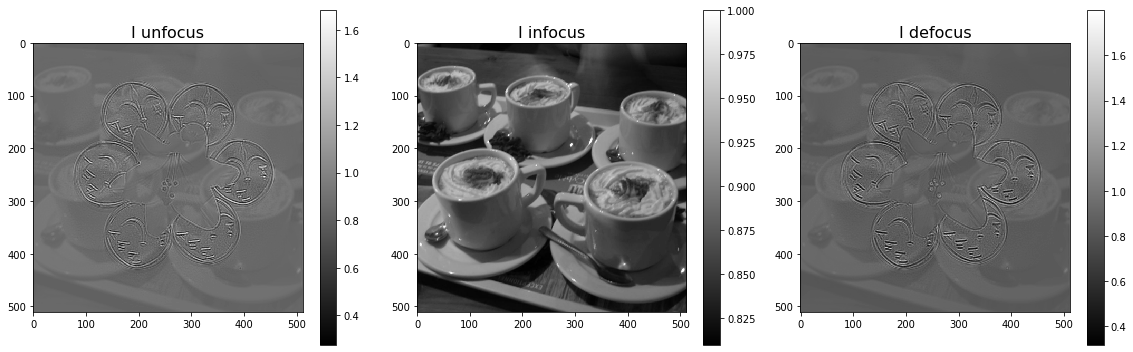

In [13]:
# visualization
name_list = ["I unfocus", "I infocus", "I defocus"]
plt.figure(figsize=[16, 5])
for i, img in enumerate([I_unfocus, I_infocus, I_defocus]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(name_list[i], fontsize=16)
    plt.colorbar()
plt.tight_layout()
plt.show()

In [14]:
# save as matlab matrix
save_path = "data/exchange_data"
if not os.path.exists(save_path):
    os.mkdir(save_path)

sio.savemat(os.path.join(save_path, "multi_focus_imgs.mat"),
            mdict={
                "wavelength": wavelength,
                "pixel_num": pixel_num,
                "pixel_size": pixel_size,
                "delta_d": d,
                "I_unfocus": I_unfocus,
                "I_infocus": I_infocus,
                "I_defocus": I_defocus
            })

# Research for TIE solution

In [1]:
import numpy as np
import sys
from pprint import pprint
sys.path.append("D:/Workspace/project/CCCode")
from imaging_process import tie_algorithm
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
datas = sio.loadmat("./data/exchange_data/multi_focus_imgs.mat")
for key in datas.keys():
    print(key)

__header__
__version__
__globals__
wavelength
pixel_num
pixel_size
delta_d
I_unfocus
I_infocus
I_defocus


In [3]:
phase = tie_algorithm(datas["I_infocus"], datas["I_unfocus"], datas["I_defocus"], datas["pixel_num"][0][0],
                      datas["delta_d"][0][0], datas["pixel_size"][0][0], datas["wavelength"][0][0], 1e8)

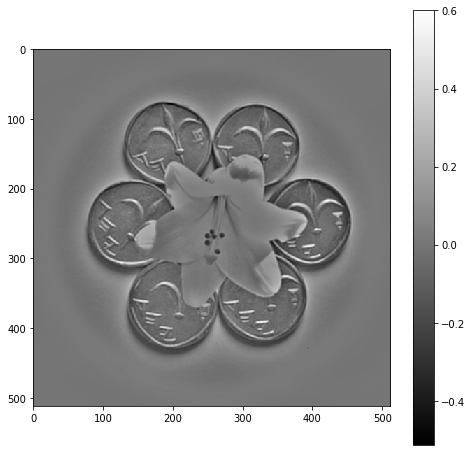

In [7]:
plt.figure(figsize=[8, 8])
plt.imshow(-phase, cmap="gray")
plt.colorbar()
plt.show()